<a href="https://colab.research.google.com/github/vkthakur90/AI_Applications/blob/master/Performace_Enhanced_Auto_Regreesion_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import seaborn as sns
from datetime import datetime, timedelta

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
ticker = 'NIFTYBEES.NS'
prev_day = 0
scale_factor = 1.0e6

history_length = 160

arima_p = 50

num_paths = 1000
paths_to_plot = 3

risk_budget = 10

In [4]:
def get_previous_trading_day(ref_date):
    """
    Given a reference date, return the previous trading day.
    This simple logic assumes that weekends are non-trading days.
    For more robust handling (e.g. holidays), consider using a market calendar.
    """
    weekday = ref_date.weekday()
    # Monday: go back to Friday (3 days)
    if weekday == 0:
        return ref_date - timedelta(days=3)
    # Sunday: go back to Friday (2 days)
    elif weekday == 6:
        return ref_date - timedelta(days=2)
    # Saturday: go back to Friday (1 day)
    elif weekday == 5:
        return ref_date - timedelta(days=1)
    else:
        # For Tuesday to Friday, subtract one day.
        return ref_date - timedelta(days=1)


In [5]:
def download_data(entity):
    # Determine today's date and then compute the previous trading day.
    today = datetime.today().date() - timedelta(days = prev_day)
    prev_trading_day = get_previous_trading_day(today)

    # Format start and end dates.
    # Note: When using yfinance, the 'end' date is non-inclusive.
    start_date = prev_trading_day.strftime("%Y-%m-%d")
    end_date = (prev_trading_day + timedelta(days=1)).strftime("%Y-%m-%d")

    print(f"Downloading {ticker} intraday data for {start_date}")

    # Download intraday data with a 1-minute interval.
    data = yf.download(ticker, start=start_date, end=end_date, interval="1m")

    if data.index.tzinfo is None:
        data.index = data.index.tz_localize('UTC')

    data.index = data.index.tz_convert('Asia/Kolkata')

    data_ = pd.DataFrame({
        'S' : data['Close'].values.reshape((-1,))
    }, index = data.index)

    entity['data'] = data_

In [6]:
def calculate_return(entity):
    data = entity['data']

    data.eval('log_S = log(S)', inplace = True)
    data['r'] = scale_factor * data['log_S'].diff()

In [7]:
def feature_engg(entity):
    data = entity['data']

    features_df = data[['S', 'r']]

    for idx in range(arima_p):
        features_df[f'r_{idx + 1}'] = features_df['r'].shift(idx + 1)

    features_df.dropna(inplace = True)

    entity['features'] = features_df

In [8]:
def split_data(entity):
    features_df = entity['features']
    train_data = features_df.iloc[: history_length]
    test_data = features_df.iloc[history_length:]

    entity['train'] = train_data
    entity['test'] = test_data

In [9]:
def fit_ar_model(entity):
    formula = 'r ~ ' + " + ".join([f'r_{idx + 1}' for idx in range(arima_p)])

    fit_model = smf.ols(formula, data = entity['train']).fit()

    entity['ar_model'] = fit_model

In [10]:
def create_vol_data(entity):
    entity['vol_train'] = pd.DataFrame({'e' : entity['ar_model'].resid})
    entity['vol_train'].eval('log_e_sq = log(e ** 2)', inplace = True)

    for idx in range(arima_p):
        entity['vol_train'][f'log_e_sq_{idx + 1}'] = entity['vol_train']['log_e_sq'].shift(idx + 1)

    entity['vol_train'].dropna(inplace = True)

In [11]:
def fit_vol_model(entity):
    formula = 'log_e_sq ~ ' + " + ".join([f'log_e_sq_{idx + 1}' for idx in range(arima_p)])

    entity['vol_model'] = smf.ols(formula, data = entity['vol_train']).fit()

    e = entity['vol_model'].resid

    N = len(e)
    ddof = N - 1 - arima_p

    var = np.sum(e ** 2)/ddof
    entity['vol_sigma'] = np.sqrt(var)

In [12]:
def forecast_mean(entity):
    prev_data = entity['train'].iloc[-arima_p:]['r'].values.tolist()
    prev_r = entity['train']['r'].iloc[-1]

    intercept = entity['ar_model'].params.values[0]
    slopes = entity['ar_model'].params.values[1:]

    dataset = []
    N = len(entity['test'])

    for idx in range(N):
        last_value = prev_data[-arima_p:]
        input_features = np.array(last_value[::-1])
        preds = intercept + np.dot(slopes, input_features)
        prev_data += [preds]

        dataset += [[preds] + input_features.tolist()]

    entity['ar_diagnosis'] = pd.DataFrame(
        data = dataset,
        columns = ['r'] + [f'r_{idx + 1}' for idx in range(arima_p)],
        index = entity['test'].index
    )

    forecast_data = prev_data[arima_p:]

    entity['mean_forecast'] = pd.DataFrame({
        'r' : forecast_data
    }, index = entity['test'].index)

In [13]:
def forecast_volatility(entity):
    prev_data = entity['vol_train'].iloc[-arima_p:]['log_e_sq'].values.tolist()

    intercept = entity['vol_model'].params.values[0]
    slopes = entity['vol_model'].params.values[1:]

    dataset = []
    N = len(entity['test'])

    for idx in range(N):
        last_value = prev_data[-arima_p:]
        input_features = np.array(last_value[::-1])
        preds = intercept + np.dot(slopes, input_features)
        prev_data += [preds]

        dataset += [[preds] + input_features.tolist()]

    entity['vol_diagnosis'] = pd.DataFrame(
        data = dataset,
        columns = ['log_e_sq'] + [f'log_e_sq_{idx + 1}' for idx in range(arima_p)],
        index = entity['test'].index
    )


    forecast_data = prev_data[arima_p:]

    entity['vol_forecast'] = pd.DataFrame({
        'log_e_sq' : forecast_data
    }, index = entity['test'].index)

    entity['vol_forecast'].eval('e = sqrt(exp(log_e_sq))', inplace = True)
    entity['vol_forecast'].eval('neg_e = -sqrt(exp(log_e_sq))', inplace = True)

In [14]:
def monte_carlo_paths(entity):
    N = len(entity['test'])
    random_numbers_1 = np.random.standard_normal(size = [N, num_paths])
    random_numbers_2 = np.random.standard_normal(size = [N, num_paths])

    prev_price = entity['train']['S'].iloc[-1]

    mean = entity['mean_forecast']['r'].values[..., np.newaxis]
    log_e_sq = entity['vol_forecast']['log_e_sq'].values[..., np.newaxis]
    vol_sigma = 0.125 * entity['vol_sigma']

    vol = np.exp(log_e_sq / 2 + (vol_sigma / np.sqrt(2)) * random_numbers_1)
    predicted_returns = mean + vol * random_numbers_2

    entity['monte_carlo_return_forecast'] = pd.DataFrame(
        data = predicted_returns,
        columns = [f'mcp_{idx + 1}' for idx in range(num_paths)],
        index = entity['test'].index
    )

    predicted_price = prev_price * np.exp(np.cumsum(predicted_returns/scale_factor, axis = 0))

    entity['monte_carlo_price_forecast'] = pd.DataFrame(
        data = predicted_price,
        columns = [f'mcp_{idx + 1}' for idx in range(num_paths)],
        index = entity['test'].index
    )

    entity['monte_carlo_quantiles'] = entity['monte_carlo_price_forecast'].quantile([0.025, 0.25, 0.50, 0.75, .975], axis = 1).T
    entity['monte_carlo_quantiles'].columns = ['low_ci', 'quart_1st', 'median', 'quart_3rd', 'high_ci']

In [15]:
def trading_strategy(entity):
    long_risk = entity['monte_carlo_quantiles']['low_ci'].min()
    short_risk = entity['monte_carlo_quantiles']['high_ci'].max()

    strategy_df = pd.DataFrame({
        'S' : entity['test']['S']
    })

    strategy_df.eval('long_var =  100 * (S - @long_risk)/S', inplace = True)
    strategy_df.eval('long_position_size = 100 * @risk_budget / long_var', inplace = True)
    strategy_df.eval('long_units = floor(long_position_size/S + 0.5)', inplace = True)
    strategy_df['prev_long_units'] = strategy_df['long_units'].shift(1)
    strategy_df['prev_long_units'].fillna(0, inplace = True)
    strategy_df.eval('delta_long_units = prev_long_units - long_units', inplace = True)

    strategy_df.eval('short_var = -100 * (S - @short_risk)/S', inplace = True)
    strategy_df.eval('short_position_size = 100 * @risk_budget / short_var', inplace = True)
    strategy_df.eval('short_units = floor(short_position_size/S + 0.5)', inplace = True)
    strategy_df['prev_short_units'] = strategy_df['short_units'].shift(1)
    strategy_df['prev_short_units'].fillna(0, inplace = True)
    strategy_df.eval('delta_short_units = -(prev_short_units - short_units)', inplace = True)

    strategy_df.eval('long_cash_flow = delta_long_units * S', inplace = True)
    strategy_df.eval('short_cash_flow = delta_short_units * S', inplace = True)

    strategy_df['cum_long_cash_flow'] = strategy_df['long_cash_flow'].cumsum()
    strategy_df['cum_short_cash_flow'] = strategy_df['short_cash_flow'].cumsum()

    strategy_df.eval('long_invested_value = S * long_units', inplace = True)
    strategy_df.eval('short_invested_value = -S * short_units', inplace = True)

    strategy_df.eval('net_long_portfolio = cum_long_cash_flow + long_invested_value', inplace = True)
    strategy_df.eval('net_short_portfolio = cum_short_cash_flow + short_invested_value', inplace = True)


    entity['strategy'] = strategy_df

In [16]:
entity = {}
download_data(entity)
calculate_return(entity)
feature_engg(entity)
split_data(entity)
fit_ar_model(entity)
create_vol_data(entity)
fit_vol_model(entity)
forecast_mean(entity)
forecast_volatility(entity)
monte_carlo_paths(entity)
trading_strategy(entity)

[*********************100%***********************]  1 of 1 completed

YF.download() has changed argument auto_adjust default to True


In [17]:
print(entity['ar_model'].summary())

                            OLS Regression Results                            
Dep. Variable:                      r   R-squared:                       0.305
Model:                            OLS   Adj. R-squared:                 -0.014
Method:                 Least Squares   F-statistic:                    0.9562
Date:                Sun, 02 Mar 2025   Prob (F-statistic):              0.561
Time:                        12:56:56   Log-Likelihood:                -1086.1
No. Observations:                 160   AIC:                             2274.
Df Residuals:                     109   BIC:                             2431.
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -43.6163     26.094     -1.672      0.0

In [18]:
print(entity['vol_model'].summary())

                            OLS Regression Results                            
Dep. Variable:               log_e_sq   R-squared:                       0.266
Model:                            OLS   Adj. R-squared:                 -0.355
Method:                 Least Squares   F-statistic:                    0.4283
Date:                Sun, 02 Mar 2025   Prob (F-statistic):              0.999
Time:                        12:56:56   Log-Likelihood:                -242.05
No. Observations:                 110   AIC:                             586.1
Df Residuals:                      59   BIC:                             723.8
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      26.5760     22.496      1.181      

<Axes: xlabel='Datetime', ylabel='r'>

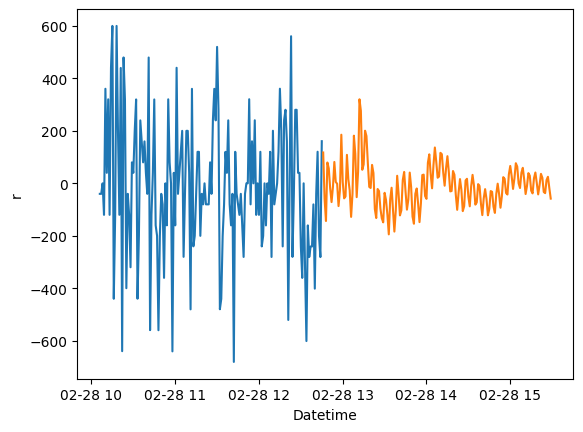

In [19]:
sns.lineplot(x = 'Datetime', y = 'r', data = entity['train'].reset_index())
sns.lineplot(x = 'Datetime', y = 'r', data = entity['mean_forecast'].reset_index())

<Axes: xlabel='Datetime', ylabel='e'>

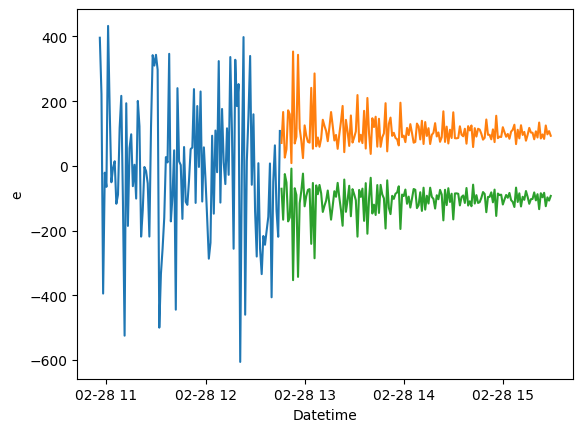

In [20]:
sns.lineplot(x = 'Datetime', y = 'e', data = entity['vol_train'].reset_index())
sns.lineplot(x = 'Datetime', y = 'e', data = entity['vol_forecast'].reset_index())
sns.lineplot(x = 'Datetime', y = 'neg_e', data = entity['vol_forecast'].reset_index())

In [21]:
selected_paths = np.random.choice(entity['monte_carlo_price_forecast'].columns, paths_to_plot, replace=False)

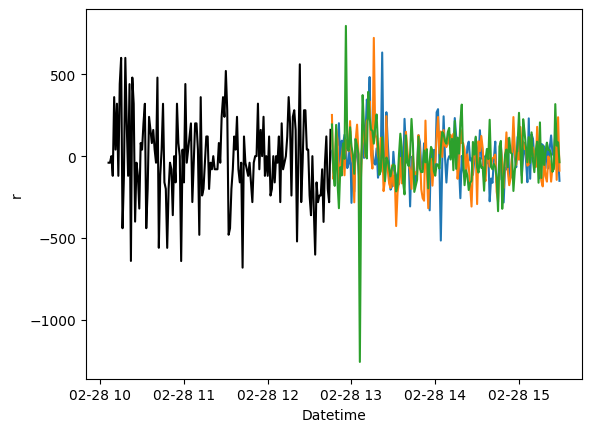

In [22]:
sns.lineplot(x = 'Datetime', y = 'r', data = entity['train'].reset_index(), color = 'black')
for p in selected_paths:
    sns.lineplot(x = 'Datetime', y = p, data = entity['monte_carlo_return_forecast'].reset_index())


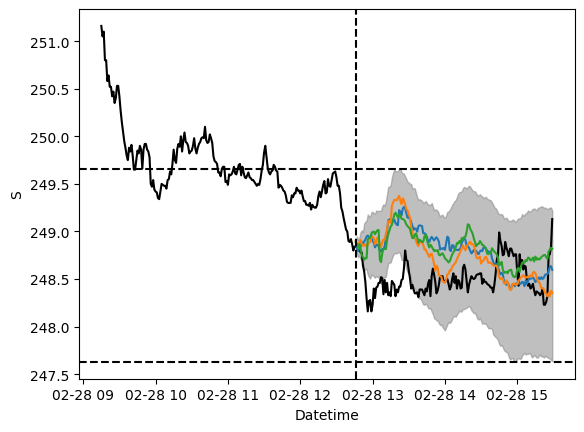

In [23]:
sns.lineplot(x = 'Datetime', y = 'S', data = entity['data'].reset_index(), color = 'black')

for p in selected_paths:
    sns.lineplot(x = 'Datetime', y = p, data = entity['monte_carlo_price_forecast'].reset_index())

plt.fill_between(entity['monte_carlo_quantiles'].index, entity['monte_carlo_quantiles']['low_ci'], entity['monte_carlo_quantiles']['high_ci'], color = 'grey', alpha = 0.5)
plt.axhline(entity['monte_carlo_quantiles']['low_ci'].min(), linestyle = '--', color = 'black')
plt.axhline(entity['monte_carlo_quantiles']['high_ci'].max(), linestyle = '--', color = 'black')
plt.axvline(entity['monte_carlo_quantiles'].index[0], linestyle = '--', color = 'black')

In [24]:
entity['monte_carlo_quantiles']['low_ci'].min()

247.62915525179326

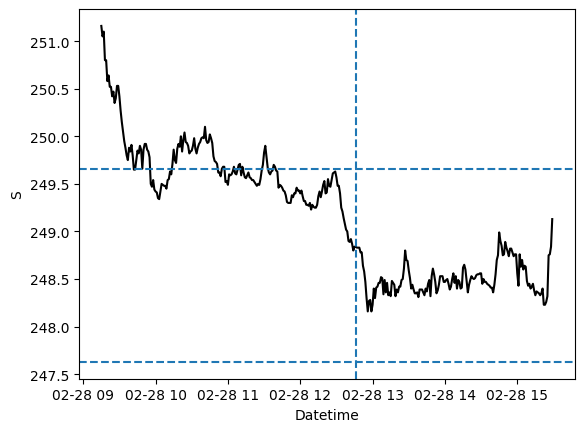

In [25]:
sns.lineplot(x = 'Datetime', y = 'S', data = entity['data'].reset_index(), color = 'black')
plt.axhline(entity['monte_carlo_quantiles']['low_ci'].min(), linestyle = '--')
plt.axhline(entity['monte_carlo_quantiles']['high_ci'].max(), linestyle = '--')
plt.axvline(entity['monte_carlo_quantiles'].index[0], linestyle = '--')

<Axes: xlabel='Datetime', ylabel='net_long_portfolio'>

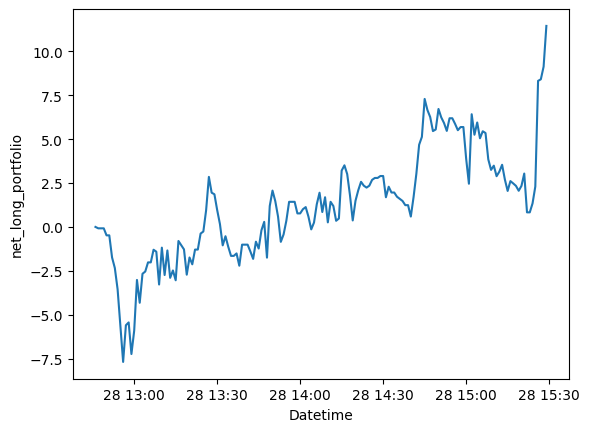

In [26]:
sns.lineplot(x = 'Datetime', y = 'net_long_portfolio', data = entity['strategy'].reset_index())

<Axes: xlabel='Datetime', ylabel='net_short_portfolio'>

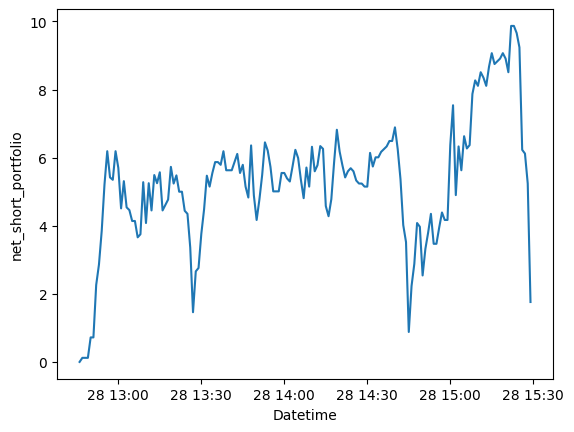

In [27]:
sns.lineplot(x = 'Datetime', y = 'net_short_portfolio', data = entity['strategy'].reset_index())

<StemContainer object of 3 artists>

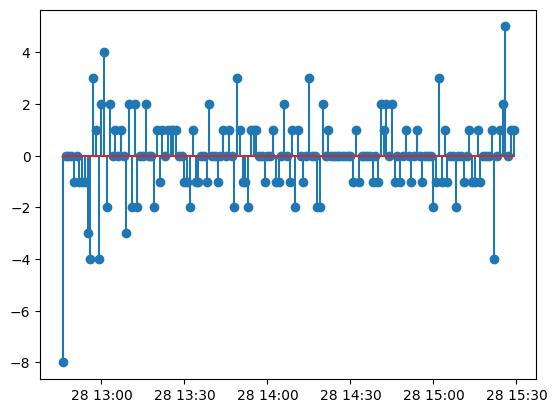

In [28]:
plt.stem(entity['strategy'].index, entity['strategy']['delta_long_units'])

<StemContainer object of 3 artists>

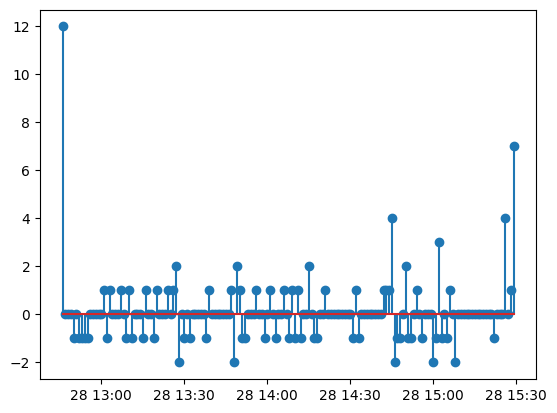

In [29]:
plt.stem(entity['strategy'].index, entity['strategy']['delta_short_units'])

In [30]:
entity['strategy']

,S,long_var,long_position_size,long_units,prev_long_units,delta_long_units,short_var,short_position_size,short_units,prev_short_units,delta_short_units,long_cash_flow,short_cash_flow,cum_long_cash_flow,cum_short_cash_flow,long_invested_value,short_invested_value,net_long_portfolio,net_short_portfolio
Datetime,,,,,,,,,,,,,,,,,,,
2025-02-28 12:46:00+05:30,248.839996,0.486594,2055.100369,8.0,0.0,-8.0,0.329445,3035.408750,12.0,0.0,12.0,-1990.719971,2986.079956,-1990.719971,2986.079956,1990.719971,-2986.079956,0.000000,0.000000
2025-02-28 12:47:00+05:30,248.830002,0.482597,2072.121503,8.0,8.0,0.0,0.333475,2998.727743,12.0,12.0,-0.0,0.000000,-0.000000,-1990.719971,2986.079956,1990.640015,-2985.960022,-0.079956,0.119934
2025-02-28 12:48:00+05:30,248.830002,0.482597,2072.121503,8.0,8.0,0.0,0.333475,2998.727743,12.0,12.0,-0.0,0.000000,-0.000000,-1990.719971,2986.079956,1990.640015,-2985.960022,-0.079956,0.119934
2025-02-28 12:49:00+05:30,248.830002,0.482597,2072.121503,8.0,8.0,0.0,0.333475,2998.727743,12.0,12.0,-0.0,0.000000,-0.000000,-1990.719971,2986.079956,1990.640015,-2985.960022,-0.079956,0.119934
2025-02-28 12:50:00+05:30,248.779999,0.462595,2161.718712,9.0,8.0,-1.0,0.353641,2827.725729,11.0,12.0,-1.0,-248.779999,-248.779999,-2239.499969,2737.299957,2239.019989,-2736.579987,-0.479980,0.719971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-28 15:25:00+05:30,248.320007,0.278210,3594.402003,14.0,16.0,2.0,0.539538,1853.439030,7.0,7.0,-0.0,496.640015,-0.000000,-3474.179977,1747.479996,3476.480103,-1738.240051,2.300125,9.239944
2025-02-28 15:26:00+05:30,248.750000,0.450591,2219.308253,9.0,14.0,5.0,0.365744,2734.156244,11.0,7.0,4.0,1243.750000,995.000000,-2230.429977,2742.479996,2238.750000,-2736.250000,8.320023,6.229996
2025-02-28 15:27:00+05:30,248.759995,0.454590,2199.782095,9.0,9.0,0.0,0.361711,2764.637146,11.0,11.0,-0.0,0.000000,-0.000000,-2230.429977,2742.479996,2238.839951,-2736.359940,8.409973,6.120056
